In [1]:
import torch
import json
import random
from torch.utils.data import Dataset
from value_network import ValueNetwork
from value_network import CubeDataset
import numpy as np
import matplotlib.pyplot as plt
from environment import RubiksCubeEnv


import numpy as np

Using device: cuda


In [2]:
def one_hot_encode(cube_state):
  # Convert the cube state to the input format expected by the model
  state_oh = []

  # Iterate over each face's colors
  for face in cube_state:
    for pair in face:
      for color in pair:
        # Create a one-hot encoded vector for this color
        color_oh = [0] * 6
        color_oh[color] = 1
        state_oh.extend(color_oh)

  return torch.tensor(state_oh, dtype=torch.float)

In [3]:
def test_model(model, cube_size, env, samples_per_cost_to_go=1000):
  """ Test the model's accuracy and average error for each cost_to_go value"""
  results = {}

  # Adjust cost_to_go_ranges based on the cube size
  if cube_size == 2:
    cost_to_go_ranges = range(0, 12)  # not inclusive
  else:
    cost_to_go_ranges = range(0, 15)  # not inclusive

  for cost_to_go in cost_to_go_ranges:
    accuracies = []
    errors = []
    predicted_costs = []

    for _ in range(samples_per_cost_to_go):
      env.reset(cost_to_go)
      state = env.get_state()  # Get the current state of the cube

      state_encoded = one_hot_encode(state).unsqueeze(0)

      with torch.no_grad():
        predicted_cost_to_go = model(
          state_encoded).item()  # Predict cost_to_go
        predicted_costs.append(predicted_cost_to_go)

      error = abs(predicted_cost_to_go - cost_to_go)
      errors.append(error)
      # Consider it accurate if the error is less or equal to 1
      accuracies.append(1 if error <= 1 else 0)

    avg_accuracy = np.mean(accuracies)
    avg_error = np.mean(errors)
    avg_predicted_cost = np.mean(predicted_costs)

    results[cost_to_go] = {
        'accuracy': avg_accuracy,
        'average_error': avg_error,
        'average_predicted_cost': avg_predicted_cost
    }

  return results

In [4]:
def load_network(model_path, input_size):
  """ Load a trained model from a file"""
  model = ValueNetwork(input_size)
  model.load_state_dict(torch.load(model_path))
  model.eval()
  return model


def load_dataset(dataset_path):
  """ Load a dataset from a file (not used anymore) """
  with open(dataset_path, 'r', encoding='utf-8-sig') as file:
    data = json.load(file)
  return CubeDataset(data)

In [13]:
def plot_combined_accuracy(results_dict):
  """ Plot the accuracy of the model for each cost_to_go value for each cube size"""
  plt.figure(figsize=(10, 6))

  colors = {'2x2x2': '#425066', '3x3x3': '#12b5cb', '4x4x4': '#e52592'}

  for title, results in results_dict.items():
      # Sort the results by cost_to_go (which are the keys of the results dict)
    sorted_costs = sorted(results.keys())
    # Access the accuracy using the sorted costs
    accuracies = [results[cost]['accuracy'] for cost in sorted_costs]
    col = colors[title] if title in colors else 'black'

    plt.plot(sorted_costs, accuracies, marker='o',
             linestyle='-', color=col, label=f'{title}')

  plt.title(
    'Dokładność sieci w zależności od cost_to_go')
  plt.xlabel('Cost-to-go')
  plt.ylabel('Dokładność')
  plt.legend()
  plt.grid(True)
  plt.savefig('combined_accuracy.png')
  plt.show()

In [14]:
def plot_combined_average_error(results_dict):
  """ Plot the average error of the model for each cost_to_go value for each cube size"""
  plt.figure(figsize=(10, 6))

  colors = {'2x2x2': '#425066', '3x3x3': '#12b5cb', '4x4x4': '#e52592'}

  for title, results in results_dict.items():
    sorted_costs = sorted(results.keys())
    errors = [results[cost]['average_error'] for cost in sorted_costs]
    col = colors[title] if title in colors else 'black'
    plt.plot(sorted_costs, errors, marker='o', linestyle='-',
             color=col, label=f'{title}')

  plt.title(
    'Średni błąd sieci w zależności od cost_to_go')
  plt.xlabel('Cost-to-go')
  plt.ylabel('Średni błąd')
  plt.legend()
  plt.grid(True)
  plt.savefig('combined_average_error.png')
  plt.show()

In [15]:
def plot_combined_predicted_cost(results_dict):
  """ Plot the average predicted cost_to_go of the model for each cost_to_go value for each cube size"""
  plt.figure(figsize=(10, 6))

  colors = {'2x2x2': '#425066', '3x3x3': '#12b5cb', '4x4x4': '#e52592'}

  for title, results in results_dict.items():
    sorted_costs = sorted(results.keys())
    predicted_costs = [results[cost]['average_predicted_cost']
                       for cost in sorted_costs]
    col = colors[title] if title in colors else 'black'
    plt.plot(sorted_costs, predicted_costs, marker='o', linestyle='-',
             color=col, label=f'{title}')

  plt.title('Średnia przewidywana wartość cost_to_go w zależności od cost_to_go')
  plt.xlabel('Cost-to-go')
  plt.ylabel('Średnia przewidywana wartość cost_to_go')
  plt.legend()
  plt.grid(True)
  plt.savefig('combined_predicted_cost.png')
  plt.show()

In [9]:
data_2x2x2 = load_dataset('./data/rubiks_cube_data_2x2x2.json')
data_3x3x3 = load_dataset('./data/rubiks_cube_data_3x3x3.json')
data_4x4x4 = load_dataset('./data/rubiks_cube_data_4x4x4.json')

results_dict = {}

env_setup = {
    'server_address': '127.0.0.1',
    'server_port': 4242,
    'cube_size': 2,
    'animation_enabled': False
}
env = RubiksCubeEnv(**env_setup)
results_dict['2x2x2'] = test_model(load_network(
  './networks/best_value_network_2x2x2.pth', 144), 2, env, 100)

env_setup = {
    'server_address': '127.0.0.1',
    'server_port': 4242,
    'cube_size': 3,
    'animation_enabled': False
  }
env = RubiksCubeEnv(**env_setup)
results_dict['3x3x3'] = test_model(load_network(
  './networks/best_value_network_3x3x3.pth', 324), 3, env, 100)

env_setup = {
    'server_address': '127.0.0.1',
    'server_port': 4242,
    'cube_size': 4,
    'animation_enabled': False
  }
env = RubiksCubeEnv(**env_setup)
results_dict['4x4x4'] = test_model(load_network(
  './networks/best_value_network_4x4x4.pth', 576), 4, env, 100)

env.close()

{'status': 'initialized'}
{'status': 'initialized'}
{'status': 'initialized'}


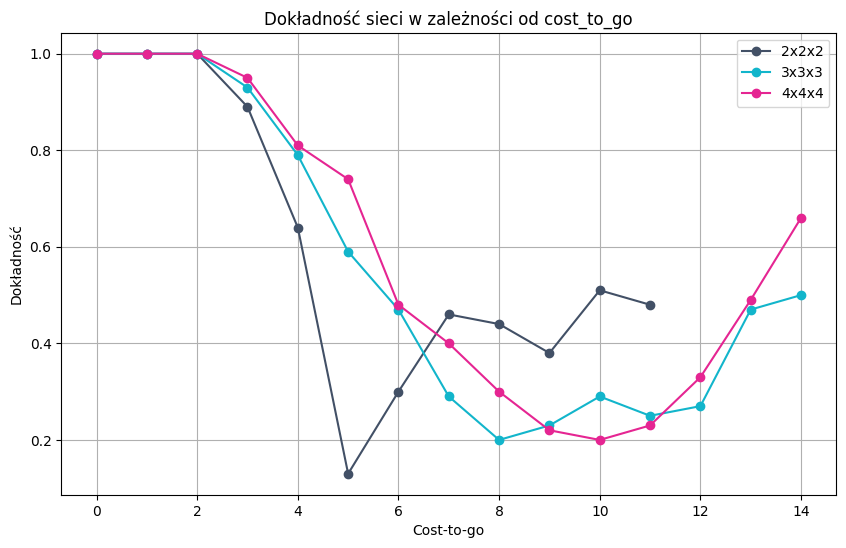

In [16]:
plot_combined_accuracy(results_dict)

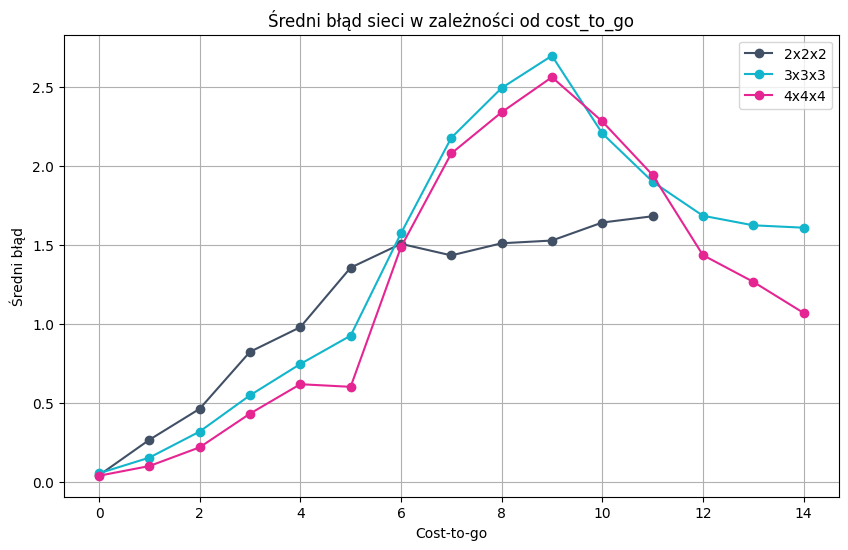

In [17]:
plot_combined_average_error(results_dict)

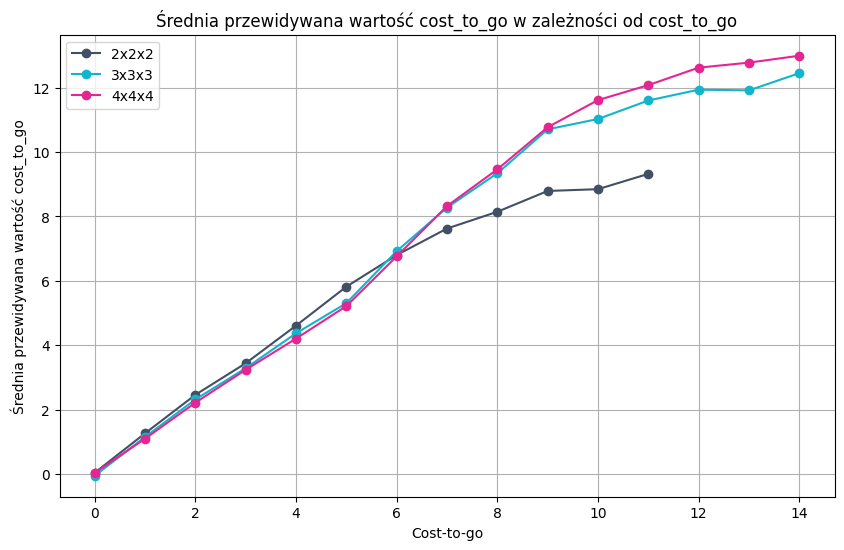

In [18]:
plot_combined_predicted_cost(results_dict)